In [2]:
import csv
import pandas as pd
import torch
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -u '/content/drive/MyDrive/CSE4238/Dataset A.zip'

Streaming output truncated to the last 5000 lines.
  inflating: training-a/a14702.png   
  inflating: training-a/a14703.png   
  inflating: training-a/a14704.png   
  inflating: training-a/a14705.png   
  inflating: training-a/a14706.png   
  inflating: training-a/a14707.png   
  inflating: training-a/a14708.png   
  inflating: training-a/a14709.png   
  inflating: training-a/a14710.png   
  inflating: training-a/a14711.png   
  inflating: training-a/a14712.png   
  inflating: training-a/a14713.png   
  inflating: training-a/a14714.png   
  inflating: training-a/a14715.png   
  inflating: training-a/a14716.png   
  inflating: training-a/a14717.png   
  inflating: training-a/a14718.png   
  inflating: training-a/a14719.png   
  inflating: training-a/a14720.png   
  inflating: training-a/a14721.png   
  inflating: training-a/a14722.png   
  inflating: training-a/a14723.png   
  inflating: training-a/a14724.png   
  inflating: training-a/a14725.png   
  inflating: training-a/a14726.png   

In [5]:
df=pd.read_csv('/content/drive/MyDrive/CSE4238/training-a.csv')

In [6]:
df.head()

,filename,original filename,scanid,digit,database name original,contributing team,database name
0,a00000.png,Scan_58_digit_5_num_8.png,58,5,BHDDB,Buet_Broncos,training-a
1,a00001.png,Scan_73_digit_3_num_5.png,73,3,BHDDB,Buet_Broncos,training-a
2,a00002.png,Scan_18_digit_1_num_3.png,18,1,BHDDB,Buet_Broncos,training-a
3,a00003.png,Scan_166_digit_7_num_3.png,166,7,BHDDB,Buet_Broncos,training-a
4,a00004.png,Scan_108_digit_0_num_1.png,108,0,BHDDB,Buet_Broncos,training-a


In [7]:
#df = pd.DataFrame(data)
df.drop(df.columns[[1, 2, 4,5,6]], axis = 1, inplace = True) 

In [8]:
df.head()

,filename,digit
0,a00000.png,5
1,a00001.png,3
2,a00002.png,1
3,a00003.png,7
4,a00004.png,0


In [9]:
df['digit'].unique()

array([5, 3, 1, 7, 0, 4, 9, 8, 2, 6])

In [10]:
df['digit'].value_counts()

2    1984
6    1983
4    1982
3    1976
0    1975
5    1965
9    1964
1    1963
7    1960
8    1950
Name: digit, dtype: int64

In [11]:
import torch
import cv2
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim
import torch.nn.functional as F
from PIL import ImageFile
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import torch.nn as nn
import torch.nn.functional as f
from skimage import io
from torch.utils.data import (
    Dataset,
    DataLoader,
) 

In [12]:
img = cv2.imread('/content/training-a/a00000.png')

In [ ]:
img.shape

In [47]:
IMAGE_SIZE = 40 
transform = transforms.Compose([
                                transforms.ToPILImage(),
                                # transforms.Grayscale(),
                                torchvision.transforms.ColorJitter(brightness=0.4,saturation=0.4,contrast=0.4,hue=0.4),
                                transforms.RandomRotation(20,expand=True), 
                                transforms.Resize(IMAGE_SIZE),  ## image resize
                                transforms.CenterCrop(IMAGE_SIZE), ## image center crop
                                transforms.ToTensor(), ## array converted into torch tensor and then divided by 255 (1.0/255)
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                
                               ])

In [48]:
class digit_Dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=True):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = cv2.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 3]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [15]:
dataset =digit_Dataset(
    csv_file='/content/drive/MyDrive/CSE4238/training-a.csv',
    root_dir='/content/training-a',
    transform=transform,
)

In [16]:
train_set, test_set = torch.utils.data.random_split(dataset, [15762, 3940])
train_loader = DataLoader(dataset=train_set, batch_size=20, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=20, shuffle=True)

In [17]:
len(train_loader)

789

In [18]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [19]:
data_iter = iter(train_loader)
images, labels = data_iter.next()
images.shape

torch.Size([20, 3, 40, 40])

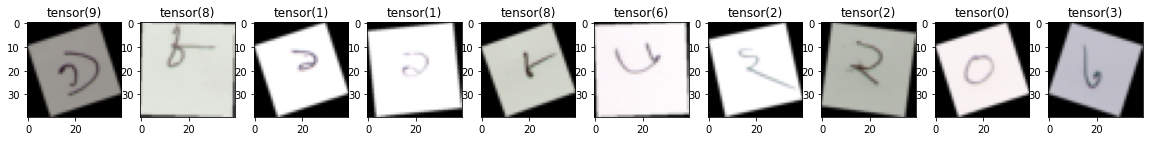

In [20]:
dataiter = iter(train_loader)
plt.subplots(figsize=(20, 40))
for i in range(10):
    plt.subplot(10/2, 10,i+1)
    img = images[i].detach().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5]) 
    std = np.array([0.5, 0.5, 0.5])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.title(labels[i])
    # print(img.shape)
    plt.imshow(img)
plt.show()

In [21]:
class Net(nn.Module): # Module is library package
    
    def __init__(self):
        super().__init__()
        
        self.fc1=nn.Linear(3*40 * 40, 200)  #flatten the image 
        self.fc2=nn.Linear(200,200)
        self.fc3=nn.Linear(200,200)
        self.fc4=nn.Linear(200,200)  
        self.fc5=nn.Linear(200,200)
        self.fc6=nn.Linear(200,10)
        
    def forward(self,x): # pass the data
        
        x=f.relu(self.fc1(x))
        x=f.relu(self.fc2(x))
        x=f.relu(self.fc3(x))
        x=f.relu(self.fc4(x))
        x=f.relu(self.fc5(x))
        
        x=self.fc6(x)
        
        return x
               

net=Net()
print(net)

Net(
  (fc1): Linear(in_features=4800, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=200, bias=True)
  (fc5): Linear(in_features=200, out_features=200, bias=True)
  (fc6): Linear(in_features=200, out_features=10, bias=True)
)


In [22]:
net.cuda()

Net(
  (fc1): Linear(in_features=4800, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=200, bias=True)
  (fc5): Linear(in_features=200, out_features=200, bias=True)
  (fc6): Linear(in_features=200, out_features=10, bias=True)
)

In [23]:
optimizer =  optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
 
criterion = torch.nn.CrossEntropyLoss()

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [25]:
device

device(type='cuda', index=0)

In [26]:
Path='./net_final.pth'
traininglosses = []
trainingaccuracy = []
testinglosses = []
testaccuracy = []
totalsteps = []
epochs = 26
steps = 0
running_loss = 0
print_every = 500

#epoch iteration
for epoch in range(epochs):
    accuracy = 0
    for inputs, labels in train_loader:
        net.train()
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad() 
        
        logps = net.forward(inputs.view(-1,3*40*40))
        loss = criterion(logps, labels)
        loss.backward() 
        optimizer.step() 
 
        #Calculate traning accuracy
        pred = torch.argmax(logps, dim=1)
        correct = pred.eq(labels)
       
        running_loss += loss.item()
        accuracy += torch.mean(correct.float())
        
        if steps % print_every == 0:
            after_train_accuracy=accuracy/print_every
            test_loss = 0
            accuracy = 0
            net.eval()
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = net.forward(inputs.view(-1,3*40*40))
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    pred = torch.argmax(logps, dim=1)
                    correct = pred.eq(labels)
                    accuracy += torch.mean(correct.float())
            
            traininglosses.append(running_loss/print_every)
            trainingaccuracy.append(after_train_accuracy)
            testinglosses.append(test_loss/len(test_loader))
            testaccuracy.append(accuracy/len(test_loader))
            totalsteps.append(steps)
            print(f"Device {device} "
                  f"Epoch {epoch+1}/{epochs} "
                  f"Steps {steps} "
                  f"Train Loss: {running_loss/print_every:f} "
                  f"Train Accuracy: {after_train_accuracy:f} "
                  f"Test Loss: {test_loss/len(test_loader):f} "
                  f"Test Accuracy: {accuracy/len(test_loader):f}")
            running_loss = 0
            accuracy = 0
            net.train()
print('Training finish')
torch.save(net.state_dict(), Path)

Device cuda:0 Epoch 1/26 Steps 500 Train Loss: 2.303283 Train Accuracy: 0.104000 Test Loss: 2.302795 Test Accuracy: 0.103046
Device cuda:0 Epoch 2/26 Steps 1000 Train Loss: 2.303255 Train Accuracy: 0.043400 Test Loss: 2.304674 Test Accuracy: 0.093147
Device cuda:0 Epoch 2/26 Steps 1500 Train Loss: 2.302701 Train Accuracy: 0.103100 Test Loss: 2.300484 Test Accuracy: 0.104315
Device cuda:0 Epoch 3/26 Steps 2000 Train Loss: 2.298579 Train Accuracy: 0.095500 Test Loss: 2.286145 Test Accuracy: 0.109645
Device cuda:0 Epoch 4/26 Steps 2500 Train Loss: 2.287773 Train Accuracy: 0.032400 Test Loss: 2.291733 Test Accuracy: 0.114213
Device cuda:0 Epoch 4/26 Steps 3000 Train Loss: 2.268290 Train Accuracy: 0.132200 Test Loss: 2.217492 Test Accuracy: 0.148731
Device cuda:0 Epoch 5/26 Steps 3500 Train Loss: 2.242113 Train Accuracy: 0.102900 Test Loss: 2.247158 Test Accuracy: 0.145431
Device cuda:0 Epoch 6/26 Steps 4000 Train Loss: 2.221412 Train Accuracy: 0.017000 Test Loss: 2.293588 Test Accuracy: 0.

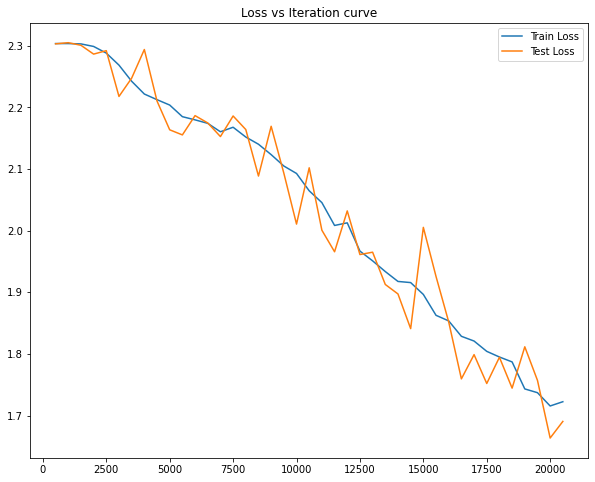

In [33]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(10)
ax.set_title('Loss vs Iteration curve')
plt.plot(totalsteps, traininglosses, label='Train Loss')
plt.plot(totalsteps, testinglosses, label='Test Loss')
plt.legend()
plt.show()

In [28]:
correct=0
total=0
with torch.no_grad():
    for data in test_loader:
        X,y=data
        X, y = X.to(device), y.to(device)
        
        output=net(X.view(-1,3*40*40))
        for idx, i in enumerate(output):
            if torch.argmax(i)==y[idx]:
                correct+=1
            total+=1
            
print(round(correct/total,3))

0.452


In [29]:
correct

1780

In [31]:
nb_classes = 10

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = net.forward(inputs.view(-1,3*40*40))
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[226.,  36.,  25.,  38.,  24.,  20.,  13.,   2.,  14.,   8.],
        [ 44., 109.,  61.,  48.,  25.,  15.,   8.,   2.,  47.,  15.],
        [ 15.,  25., 155.,  22., 120.,  19.,   6.,  11.,  35.,   2.],
        [ 14.,  27.,  15., 223.,  28.,  15.,  21.,   5.,  15.,   4.],
        [  9.,  11.,  27.,  23., 287.,   8.,   8.,  10.,  19.,   4.],
        [ 23.,  25.,  38.,  58.,  12., 116.,  39.,  55.,  36.,   4.],
        [  2.,  14.,   6.,  38.,   0.,  25., 246.,  38.,  23.,   1.],
        [  1.,  20.,  42.,  24.,   3.,  57.,  18., 214.,  15.,   2.],
        [ 15.,  23.,  34.,  11.,  34.,   7.,   6.,   2., 240.,   9.],
        [ 29.,  65.,  52.,  57.,  41.,  29.,  10.,  17.,  86.,  15.]])


Text(0.5, 51.0, 'Predicted label')

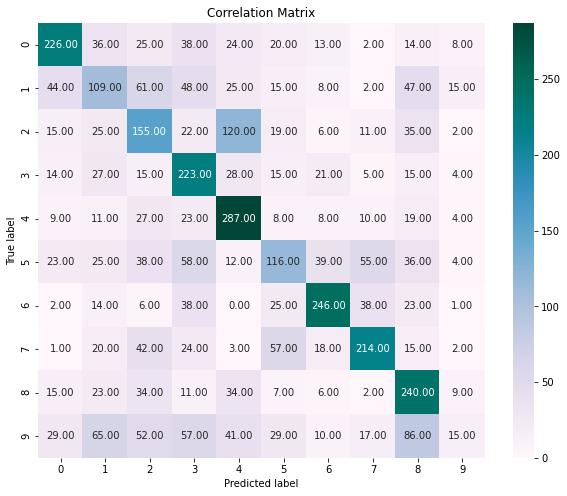

In [35]:
import pandas as pd
import seaborn as sns
class_names = ["0","1","2","3","4","5","6","7","8","9"]
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
f, ax = plt.subplots(figsize= [10,8])
sns.heatmap(df_cm, annot=True, fmt=".2f", ax=ax, cmap = "PuBuGn" )
ax.set_title("Correlation Matrix", fontsize=12)
plt.ylabel('True label')
plt.xlabel('Predicted label')